
📊 Model Evaluation:
XGBoost - MAPE: 7.52%, MSE: 48137300.72, R²: -0.1189
Gradient Boosting - MAPE: 7.55%, MSE: 53706756.69, R²: -0.2484
Random Forest - MAPE: 3.92%, MSE: 15480391.77, R²: 0.6402


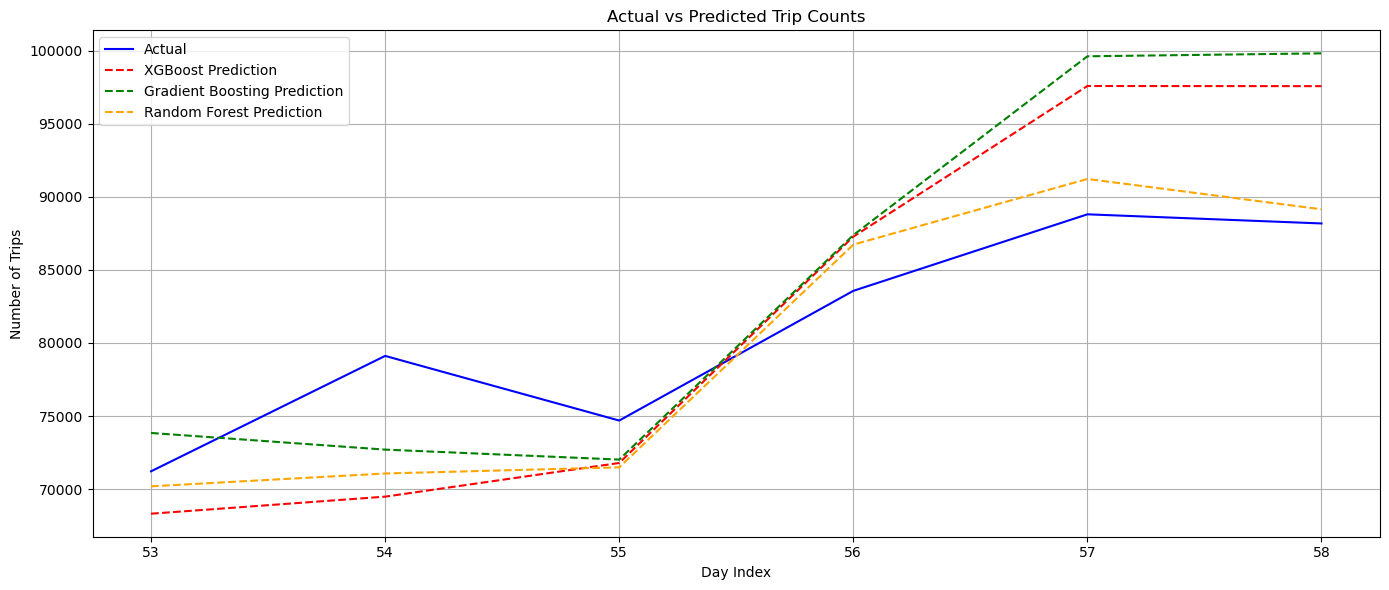


🧬 Ensemble MAPE: 5.45%


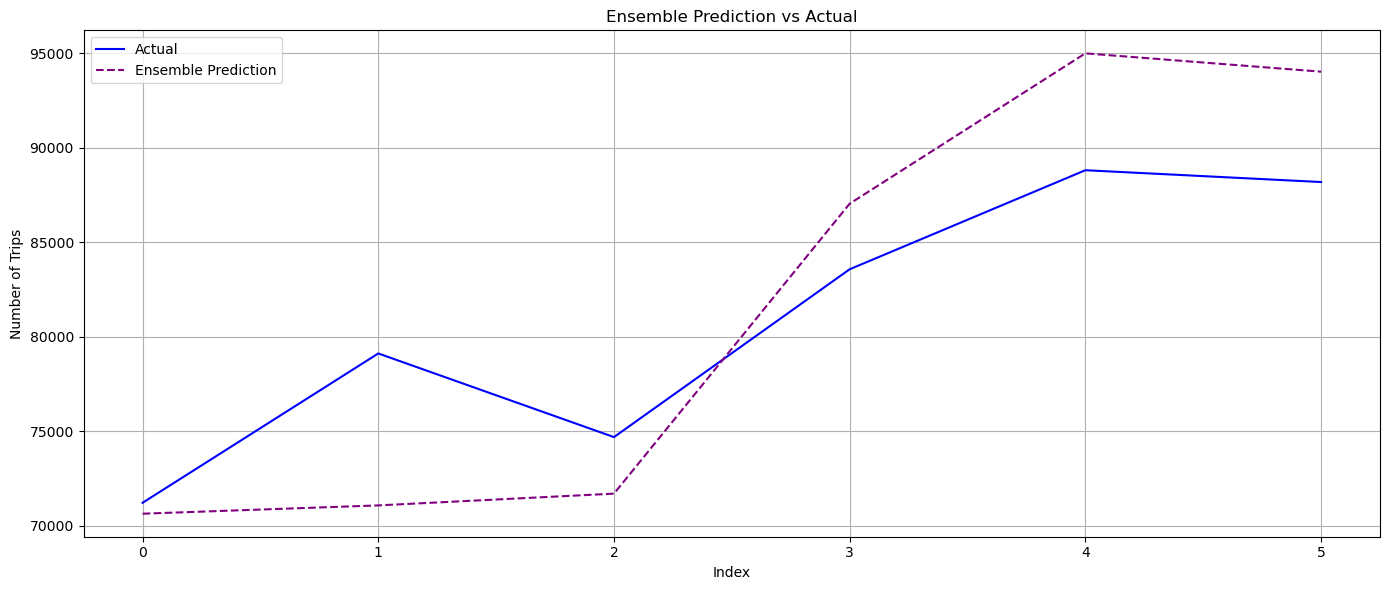


📊 Final Comparison:
Model                MAPE (%)   MSE        R² Score
--------------------------------------------------
XGBoost              7.52%     48137300.72    -0.1189
Gradient Boosting    7.55%     53706756.69    -0.2484
Random Forest        3.92%     15480391.77    0.6402
Ensemble             5.45%     26363177.28    0.3872


In [12]:
# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Step 2: Load and Prepare Data
df = pd.read_csv('Uber-Jan-Feb-FOIL.csv')

# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Aggregate total trips per day across all bases
daily_trips = df.groupby('date').agg({'trips': 'sum'}).reset_index()
daily_trips.columns = ['Date', 'Trips']

# Sort by date
daily_trips.sort_values(by='Date', inplace=True)
daily_trips.reset_index(drop=True, inplace=True)

# Step 3: Feature Engineering
daily_trips['Day_of_Week'] = daily_trips['Date'].dt.dayofweek
daily_trips['Month'] = daily_trips['Date'].dt.month
daily_trips['Year'] = daily_trips['Date'].dt.year
daily_trips['Day_of_Year'] = daily_trips['Date'].dt.dayofyear
daily_trips['Week_of_Year'] = daily_trips['Date'].dt.isocalendar().week.astype(int)

# Add lagged features
daily_trips['Lag_1'] = daily_trips['Trips'].shift(1)
daily_trips['Lag_7'] = daily_trips['Trips'].shift(7)
daily_trips['Lag_30'] = daily_trips['Trips'].shift(30)

# Drop missing values created by lags
daily_trips.dropna(inplace=True)

# Define feature matrix and target variable
X = daily_trips[['Day_of_Week', 'Month', 'Year', 'Day_of_Year', 'Week_of_Year', 'Lag_1', 'Lag_7', 'Lag_30']]
y = daily_trips['Trips']


# Step 4: Train-Test Split (Time-Aware)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Step 5: Train Models

# XGBoost
xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Gradient Boosting
gbr_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
gbr_model.fit(X_train, y_train)
y_pred_gbr = gbr_model.predict(X_test)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Step 6: Evaluate Models
def evaluate_model(name, y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name} - MAPE: {mape:.2f}%, MSE: {mse:.2f}, R²: {r2:.4f}")
    return mape, mse, r2

print("\n📊 Model Evaluation:")
xgb_metrics = evaluate_model("XGBoost", y_test, y_pred_xgb)
gbr_metrics = evaluate_model("Gradient Boosting", y_test, y_pred_gbr)
rf_metrics = evaluate_model("Random Forest", y_test, y_pred_rf)

# Step 7: Visualize Actual vs Predicted Trips
plt.figure(figsize=(14, 6))
sns.lineplot(x=y_test.index, y=y_test.values, label="Actual", color='blue')
sns.lineplot(x=y_test.index, y=y_pred_xgb, label="XGBoost Prediction", color='red', linestyle='--')
sns.lineplot(x=y_test.index, y=y_pred_gbr, label="Gradient Boosting Prediction", color='green', linestyle='--')
sns.lineplot(x=y_test.index, y=y_pred_rf, label="Random Forest Prediction", color='orange', linestyle='--')
plt.title("Actual vs Predicted Trip Counts")
plt.xlabel("Day Index")
plt.ylabel("Number of Trips")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 8: Ensemble Prediction Using Weighted Average
weights = [1 / xgb_metrics[0], 1 / gbr_metrics[0], 1 / rf_metrics[0]]
weights = np.array(weights) / sum(weights)  # Normalize

ensemble_pred = weights[0] * y_pred_xgb + weights[1] * y_pred_gbr + weights[2] * y_pred_rf
ensemble_mape = mean_absolute_percentage_error(y_test, ensemble_pred) * 100

print(f"\n🧬 Ensemble MAPE: {ensemble_mape:.2f}%")

# Step 9: Plot Ensemble Performance
plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label="Actual", color='blue')
plt.plot(ensemble_pred, label="Ensemble Prediction", color='purple', linestyle='--')
plt.title("Ensemble Prediction vs Actual")
plt.xlabel("Index")
plt.ylabel("Number of Trips")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 10: Final Comparison Table
print("\n📊 Final Comparison:")
print(f"{'Model':<20} {'MAPE (%)':<10} {'MSE':<10} {'R² Score'}")
print("-" * 50)
print(f"{'XGBoost':<20} {xgb_metrics[0]:.2f}%     {xgb_metrics[1]:.2f}    {xgb_metrics[2]:.4f}")
print(f"{'Gradient Boosting':<20} {gbr_metrics[0]:.2f}%     {gbr_metrics[1]:.2f}    {gbr_metrics[2]:.4f}")
print(f"{'Random Forest':<20} {rf_metrics[0]:.2f}%     {rf_metrics[1]:.2f}    {rf_metrics[2]:.4f}")
print(f"{'Ensemble':<20} {ensemble_mape:.2f}%     {mean_squared_error(y_test, ensemble_pred):.2f}    {r2_score(y_test, ensemble_pred):.4f}")

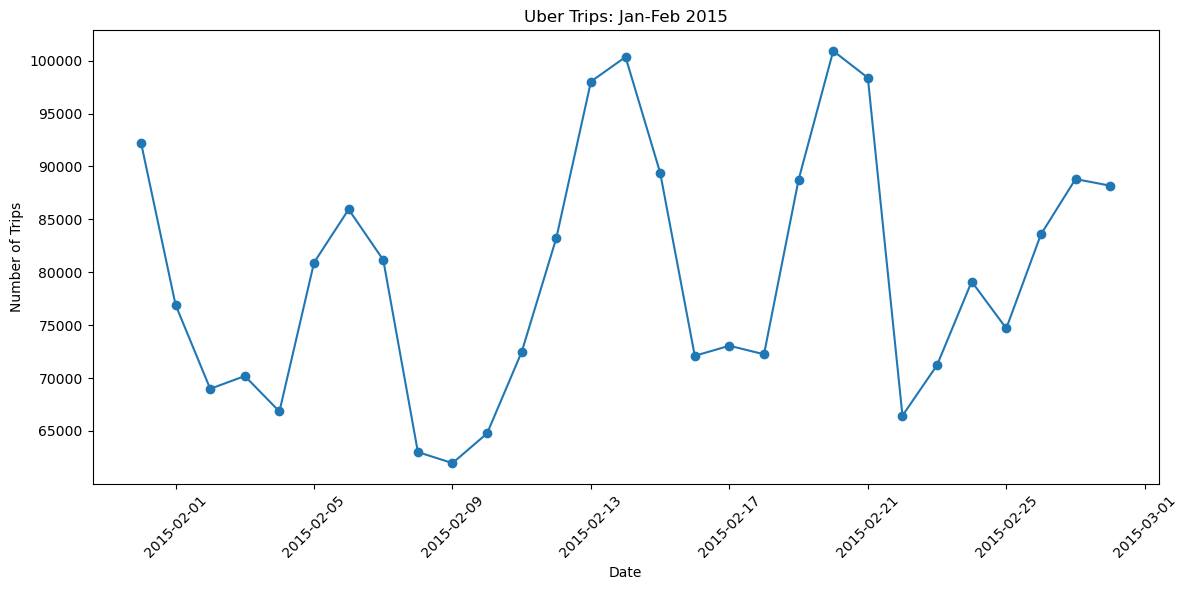

In [15]:
# Plot total daily trips
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(daily_trips['Date'], daily_trips['Trips'], marker='o')
plt.title("Uber Trips: Jan-Feb 2015")
plt.xlabel("Date")
plt.ylabel("Number of Trips")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()